In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import datetime
import warnings
warnings.filterwarnings('ignore')

C:\Users\shinj\anaconda3\envs\ML\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\shinj\anaconda3\envs\ML\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\Users\shinj\anaconda3\envs\ML\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
df_price = pd.read_csv(r'D:/shinj/webCrawling/01-삼성전자-주가.csv', encoding='utf8')

In [3]:
df_price.head()

,일자,시가,고가,저가,종가,거래량
0,20200107,55700,56400,55600,55800,9893846
1,20200106,54900,55600,54600,55500,10278951
2,20200103,56000,56600,54900,55500,15422255
3,20200102,55500,56000,55000,55200,12993228
4,20191230,56200,56600,55700,55800,8356767


In [4]:
pd.to_datetime(df_price['일자'], format='%Y%m%d')
df_price['일자'] = pd.to_datetime(df_price['일자'], format='%Y%m%d')
df_price['연도'] =df_price['일자'].dt.year
df_price['월'] =df_price['일자'].dt.month
df_price['일'] =df_price['일자'].dt.day

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
df_scaled = scaler.fit_transform(df_price[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

            시가        고가        저가        종가       거래량
0     0.968632  0.980489  0.979522  0.975133  0.030291
1     0.954691  0.966553  0.961868  0.969880  0.031470
2     0.973860  0.983973  0.967164  0.969880  0.047217
3     0.965147  0.973521  0.968929  0.964626  0.039781
4     0.977346  0.983973  0.981287  0.975133  0.025585
...        ...       ...       ...       ...       ...
9283  0.000174  0.000174  0.000124  0.000123  0.000995
9284  0.000227  0.000226  0.000212  0.000193  0.002587
9285  0.000227  0.000244  0.000229  0.000228  0.002363
9286  0.000227  0.000226  0.000229  0.000210  0.000332
9287  0.000244  0.000244  0.000247  0.000228  0.000342

[9288 rows x 5 columns]


In [6]:
TEST_SIZE = 200
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [33]:
def make_dataset(data, label, window_size=3):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [34]:
feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape

# test dataset 
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 4), (180, 1))

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
import os

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [36]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_path = ('D:\shinj\webCrawling')
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=50,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
140/146 [===========================>..] - ETA: 0s - loss: 0.0091
Epoch 00001: val_loss improved from inf to 0.00048, saving model to D:\shinj\webCrawling\tmp_checkpoint.h5
146/146 [==============================] - 1s 7ms/step - loss: 0.0088 - val_loss: 4.7884e-04
Epoch 2/200
139/146 [===========================>..] - ETA: 0s - loss: 2.0844e-04
Epoch 00002: val_loss improved from 0.00048 to 0.00009, saving model to D:\shinj\webCrawling\tmp_checkpoint.h5
146/146 [==============================] - 1s 5ms/step - loss: 2.0409e-04 - val_loss: 8.9605e-05
Epoch 3/200
140/146 [===========================>..] - ETA: 0s - loss: 9.2396e-05- ETA: 0s - loss
Epoch 00003: val_loss improved from 0.00009 to 0.00007, saving model to D:\shinj\webCrawling\tmp_checkpoint.h5
146/146 [==============================] - 1s 5ms/step - loss: 9.1679e-05 - val_loss: 7.1300e-05
Epoch 4/200
145/146 [============================>.] - ETA: 0s - loss: 7.8529e-05
Epoch 00004: val_loss did not improve from 0

141/146 [===========================>..] - ETA: 0s - loss: 3.2299e-05
Epoch 00032: val_loss did not improve from 0.00003
146/146 [==============================] - 1s 5ms/step - loss: 3.2420e-05 - val_loss: 2.5109e-05
Epoch 33/200
145/146 [============================>.] - ETA: 0s - loss: 3.1619e-05
Epoch 00033: val_loss did not improve from 0.00003
146/146 [==============================] - 1s 5ms/step - loss: 3.1604e-05 - val_loss: 2.6087e-05
Epoch 34/200
138/146 [===========================>..] - ETA: 0s - loss: 2.7848e-05
Epoch 00034: val_loss improved from 0.00003 to 0.00002, saving model to D:\shinj\webCrawling\tmp_checkpoint.h5
146/146 [==============================] - 1s 5ms/step - loss: 2.7512e-05 - val_loss: 2.4169e-05
Epoch 35/200
139/146 [===========================>..] - ETA: 0s - loss: 2.6581e-05
Epoch 00035: val_loss improved from 0.00002 to 0.00002, saving model to D:\shinj\webCrawling\tmp_checkpoint.h5
146/146 [==============================] - 1s 5ms/step - loss: 2.6

In [37]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

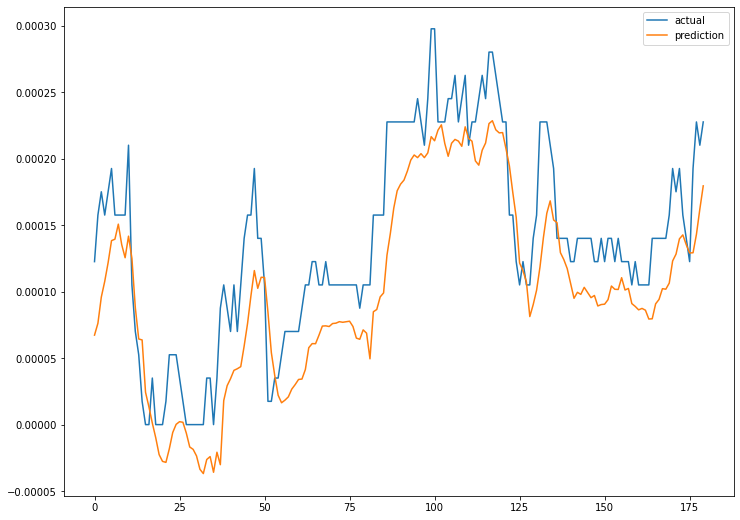

In [38]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()